# Pure Open Markets: Backtesting the Optimal Strategy with Moving Investment Universe

# 0. Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn
seaborn.set()
import wrds

WRDS_LOGIN = 'pedrou'    # update to your login info on CRSP
DATAPATH = '~/Downloads/mathematical_finance/data/'

### Check which databases are there stored in the `CRSP_monthly_cleaned.h5` dataframe.

In [2]:
with pd.HDFStore(DATAPATH + 'CRSP_monthly_cleaned.h5') as store:
    # Get the first level of the MultiIndex (column names)
    column_names = store['df'].columns.get_level_values(0)
    
    # Convert the column names to a set to get unique values
    unique_column_names = set(column_names)
    
    print('Databases in CRSP_monthly_cleaned: ' + str(unique_column_names))
    print(store.keys())

Databases in CRSP_monthly_cleaned: {'bcktstflg', 'mthret', 'mthprevcap'}
['/df']


# 1. Selecting the Dataset

## 1.1. Choosing the Investment Universe and Time Period

The Investment Universe is made up of all the common shares. Johannes Ruf defines common shares as those who satisfy the following conditions:

a) `sharetype` equals `NS` ('not specified', other types could be ADRs or certificates, for example);

b) `securitysubtype` equals `COM` (for `common`, other types could be closed-end funds, for example);

c) `issuertype` is either `ACOR` or `CORP` ((assumed) corporation; there is only one other type, namely REITs);

d) `usincflg` equals `Y` (US-incorporated).

There is another relevant column, namely `securitytype`, which describers whether the security is a stock, a derivative, or a fund. However, we don't have to check it since condition a) above already implies that `securitytype` always equals `EQTY`.

We have already cleaned the data using Johannes Ruf's code, so we just need to load it.

In [3]:
with pd.HDFStore(DATAPATH + 'CRSP_monthly_cleaned.h5') as store:
    mktcaps_raw = store['df']['mthprevcap']

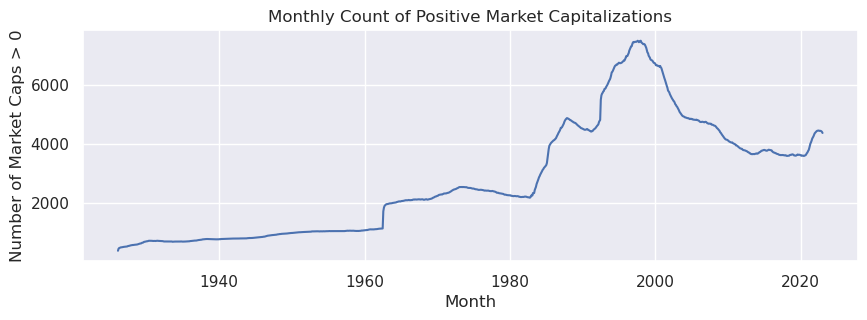

In [4]:
# Step 1: Create a boolean DataFrame where True represents market_caps > 0
positive_market_caps = mktcaps_raw.gt(0)

# Step 2: Count the number of True values in each row (month) of the DataFrame
monthly_positive_counts = positive_market_caps.sum(axis=1)

# Step 3: Create the plot
plt.figure(figsize=(10, 3))
plt.plot(monthly_positive_counts.index, monthly_positive_counts)
plt.xlabel("Month")
plt.ylabel("Number of Market Caps > 0")
plt.title("Monthly Count of Positive Market Capitalizations")
plt.show()

In [7]:
def find_first_date_with_threshold(monthly_positive_counts, threshold):
    for date, count in monthly_positive_counts.items():
        if count >= threshold:
            print('First date with more than '+str(threshold)+' positive market capitalizations:', date)
            return date

    return None

find_first_date_with_threshold(monthly_positive_counts, 2000)
find_first_date_with_threshold(monthly_positive_counts, 3000)
find_first_date_with_threshold(monthly_positive_counts, 4000)

First date with more than 2000 positive market capitalizations: 1964-02-28 00:00:00
First date with more than 3000 positive market capitalizations: 1984-04-30 00:00:00
First date with more than 4000 positive market capitalizations: 1985-08-30 00:00:00


Timestamp('1985-08-30 00:00:00')

If we want our investment universe to be of size 2000 we can choose to start from 1965 onward, while if we wanted 3000 we could start from 1985. We start working with `d = 2000` and the starting date for our backtesting will be January 1965:

In [7]:
d = 2000
start_date = '1965-01-01'

## 1.2. Creating the Dataframe to Work With

Let's create the dataframe with monthly data since 1973, where we will be only looking at the performance until now of top d stocks in 1973. The resulting dataframe will contain, for each month and permno:
- Its total market capitalization.
- Its relative market capitalization.
- Its rank.
- Its return for that time period.

### Step 1: Prepare Market Capitalizations Dataset.

#### Step 1.0: Understanding `market_caps`.

In [8]:
# Access a specific value using row and column index:
value = mktcaps_raw.loc['1926-01-30', 10006.0]
value

65400.0

In [9]:
print("\nConcise summary of the DataFrame:")
print(mktcaps_raw.info())


Concise summary of the DataFrame:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1164 entries, 1926-01-30 to 2022-12-30
Columns: 22353 entries, 10001.0 to 93436.0
dtypes: float64(22353)
memory usage: 198.5 MB
None


In [10]:
# Access an entire row using the row index:
row = mktcaps_raw.loc['1926-01-30']
print(len(row))
row.head(7)

22353


permno
10001.0        NaN
10002.0        NaN
10003.0        NaN
10006.0    65400.0
10008.0        NaN
10009.0        NaN
10010.0        NaN
Name: 1926-01-30 00:00:00, dtype: float64

In [11]:
# Access an entire column using the column index:
column = mktcaps_raw[10006.0]
print(len(column))
column.head(5)

1164


mthcaldt
1926-01-30    65400.0
1926-02-27    66150.0
1926-03-31    61425.0
1926-04-30    57900.0
1926-05-28    56400.0
Name: 10006.0, dtype: float64

In [12]:
# Select a subset of the DataFrame using slicing:
subset = mktcaps_raw.loc['1926-01-30':'1926-03-31', 10006.0:10008.0]
subset

permno,10006.0,10008.0
mthcaldt,,
1926-01-30,65400.0,NaN
1926-02-27,66150.0,NaN
1926-03-31,61425.0,NaN


In [13]:
# Using iloc to access elements by position (row and column number):
element = mktcaps_raw.iloc[0, 6]
element

nan

In [14]:
# Access values based on a condition:
selected_values = mktcaps_raw[mktcaps_raw > 1000]
selected_values.head(3)

permno,10001.0,10002.0,10003.0,10006.0,10008.0,10009.0,10010.0,10011.0,10012.0,10014.0,...,93423.0,93426.0,93428.0,93429.0,93430.0,93432.0,93433.0,93434.0,93435.0,93436.0
mthcaldt,,,,,,,,,,,,,,,,,,,,,
1926-01-30,NaN,NaN,NaN,65400.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1926-02-27,NaN,NaN,NaN,66150.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1926-03-31,NaN,NaN,NaN,61425.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
# Apply a function to each element in the DataFrame:
def double(x):
    return 2 * x
doubled_mktcaps = mktcaps_raw.applymap(double)
print(doubled_mktcaps.head(3))

permno      10001.0  10002.0  10003.0   10006.0  10008.0  10009.0  10010.0  \
mthcaldt                                                                     
1926-01-30      NaN      NaN      NaN  130800.0      NaN      NaN      NaN   
1926-02-27      NaN      NaN      NaN  132300.0      NaN      NaN      NaN   
1926-03-31      NaN      NaN      NaN  122850.0      NaN      NaN      NaN   

permno      10011.0  10012.0  10014.0  ...  93423.0  93426.0  93428.0  \
mthcaldt                               ...                              
1926-01-30      NaN      NaN      NaN  ...      NaN      NaN      NaN   
1926-02-27      NaN      NaN      NaN  ...      NaN      NaN      NaN   
1926-03-31      NaN      NaN      NaN  ...      NaN      NaN      NaN   

permno      93429.0  93430.0  93432.0  93433.0  93434.0  93435.0  93436.0  
mthcaldt                                                                   
1926-01-30      NaN      NaN      NaN      NaN      NaN      NaN      NaN  
1926-02-27     

#### Step 1.1: Remove data before the start date

In [16]:
market_caps = mktcaps_raw[mktcaps_raw.index >= start_date]
market_caps.head(3)

permno,10001.0,10002.0,10003.0,10006.0,10008.0,10009.0,10010.0,10011.0,10012.0,10014.0,...,93423.0,93426.0,93428.0,93429.0,93430.0,93432.0,93433.0,93434.0,93435.0,93436.0
mthcaldt,,,,,,,,,,,,,,,,,,,,,
1965-01-29,NaN,NaN,NaN,235956.0,NaN,NaN,NaN,NaN,NaN,8422.500,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1965-02-26,NaN,NaN,NaN,248570.0,NaN,NaN,NaN,NaN,NaN,8843.625,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1965-03-31,NaN,NaN,NaN,239666.0,NaN,NaN,NaN,NaN,NaN,9264.750,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Step 2: Prepare the Returns Dataset.

In [17]:
with pd.HDFStore(DATAPATH + 'CRSP_monthly_cleaned.h5') as store:
    raw_returns = store['df']['mthret']

In [18]:
returns = raw_returns[raw_returns.index >= start_date]

In [19]:
print(len(market_caps.keys()))
returns.head(3)

22353


permno,10001.0,10002.0,10003.0,10006.0,10008.0,10009.0,10010.0,10011.0,10012.0,10014.0,...,93423.0,93426.0,93428.0,93429.0,93430.0,93432.0,93433.0,93434.0,93435.0,93436.0
mthcaldt,,,,,,,,,,,,,,,,,,,,,
1965-01-29,NaN,NaN,NaN,0.053459,NaN,NaN,NaN,NaN,NaN,0.050000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1965-02-26,NaN,NaN,NaN,-0.026120,NaN,NaN,NaN,NaN,NaN,0.047619,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1965-03-31,NaN,NaN,NaN,0.040248,NaN,NaN,NaN,NaN,NaN,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Step 4: Prepare Market Weights Dataset

We first need to remove the smallest capitalizations in the market_caps dataset so that our investment universe is actually correct when calculating the market weights.

In [20]:
market_caps.head(2)

permno,10001.0,10002.0,10003.0,10006.0,10008.0,10009.0,10010.0,10011.0,10012.0,10014.0,...,93423.0,93426.0,93428.0,93429.0,93430.0,93432.0,93433.0,93434.0,93435.0,93436.0
mthcaldt,,,,,,,,,,,,,,,,,,,,,
1965-01-29,NaN,NaN,NaN,235956.0,NaN,NaN,NaN,NaN,NaN,8422.500,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1965-02-26,NaN,NaN,NaN,248570.0,NaN,NaN,NaN,NaN,NaN,8843.625,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
# Step 1: Create a copy of the original DataFrame
filtered_market_caps = market_caps.copy()

# Step 2: For each row, sort the values and set values not in the top d to 0
for date, row in filtered_market_caps.iterrows():
    # Sort the values in descending order
    sorted_row = row.sort_values(ascending=False)
    
    # Get the index of the top d values
    top_d_index = sorted_row.iloc[:d].index
    
    # Set values not in the top d to 0
    row[~row.index.isin(top_d_index)] = np.nan

# Step 3: Reconstruct the DataFrame with the modified values
filtered_market_caps = pd.DataFrame(filtered_market_caps)

In [22]:
filtered_market_caps.head(2)

permno,10001.0,10002.0,10003.0,10006.0,10008.0,10009.0,10010.0,10011.0,10012.0,10014.0,...,93423.0,93426.0,93428.0,93429.0,93430.0,93432.0,93433.0,93434.0,93435.0,93436.0
mthcaldt,,,,,,,,,,,,,,,,,,,,,
1965-01-29,NaN,NaN,NaN,235956.0,NaN,NaN,NaN,NaN,NaN,8422.500,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1965-02-26,NaN,NaN,NaN,248570.0,NaN,NaN,NaN,NaN,NaN,8843.625,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
# Check that for every date (row) there are only d non-NaN values
all_rows_have_d_values = True

for date, row in filtered_market_caps.iterrows():
    non_nan_count = row.notna().sum()
    if non_nan_count != d:
        print(f"Row {date} has {non_nan_count} non-NaN values instead of {d}")
        all_rows_have_d_values = False
        break

if all_rows_have_d_values:
    print("All rows have exactly", d, "non-NaN values.")
else:
    print("Some rows do not have exactly", d, "non-NaN values.")

All rows have exactly 2000 non-NaN values.


Calculate the relative market capitalization weights for the top d stocks:

In [24]:
market_weights = filtered_market_caps.div(filtered_market_caps.sum(axis=1), axis=0)
market_weights = market_weights.fillna(0)

In [25]:
market_weights.tail(3)

permno,10001.0,10002.0,10003.0,10006.0,10008.0,10009.0,10010.0,10011.0,10012.0,10014.0,...,93423.0,93426.0,93428.0,93429.0,93430.0,93432.0,93433.0,93434.0,93435.0,93436.0
mthcaldt,,,,,,,,,,,,,,,,,,,,,
2022-10-31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000041,0.0,0.0,0.000349,0.0,0.0,0.0,0.0,0.0,0.023517
2022-11-30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000048,0.0,0.0,0.000344,0.0,0.0,0.0,0.0,0.0,0.018737
2022-12-30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000050,0.0,0.0,0.000336,0.0,0.0,0.0,0.0,0.0,0.015339


Small check: Weights some up to one.

In [26]:
market_weights_sum = market_weights.sum(axis=1)
print(market_weights_sum)

mthcaldt
1965-01-29    1.0
1965-02-26    1.0
1965-03-31    1.0
1965-04-30    1.0
1965-05-28    1.0
             ... 
2022-08-31    1.0
2022-09-30    1.0
2022-10-31    1.0
2022-11-30    1.0
2022-12-30    1.0
Length: 696, dtype: float64


### Step 7: Prepare Ranked Market Weights Dataframe Indexed by Rank

In [27]:
# Create a copy of the original dataframe
weights_by_rank = market_weights.copy()

# Sort each row in descending order and select the top d values
weights_by_rank = weights_by_rank.apply(lambda x: x.sort_values(ascending=False).head(d).reset_index(drop=True), axis=1)

# Rename the columns to be the rank
weights_by_rank.columns = np.arange(len(weights_by_rank.columns)) + 1

In [28]:
weights_by_rank.head(3)

,1,2,3,4,5,6,7,8,9,10,...,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000
mthcaldt,,,,,,,,,,,,,,,,,,,,,
1965-01-29,0.074882,0.058624,0.040830,0.030144,0.024896,0.023274,0.020658,0.017738,0.012739,0.011723,...,0.000004,0.000004,0.000004,0.000004,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003
1965-02-26,0.071669,0.058544,0.038165,0.031831,0.023814,0.022908,0.020091,0.018226,0.012598,0.012578,...,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004
1965-03-31,0.071080,0.056807,0.035534,0.032139,0.022956,0.021503,0.020365,0.018201,0.012488,0.011709,...,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004


In [29]:
# Test the weights_by_rank DataFrame is correctly sorted
is_sorted = all(weights_by_rank.apply(lambda row: all(row.iloc[i] >= row.iloc[i+1] for i in range(len(row)-1)), axis=1))
print("All rows sorted in descending order:", is_sorted)


All rows sorted in descending order: True


### Step 8: Prepare Market Weights + Permno Dataframe Indexed by Rank

Let us create a dataframe similar to weights_by_rank but with values the market weight and also the permno, so that we can later access the return of a stock only given its rank easily.

In [30]:
# Create a copy of the original dataframe
weights_permno_by_rank = market_weights.copy()

# For each row, sort the market weights in descending order, then create tuples of (market_weight, permno) and keep only the top d
weights_permno_by_rank = weights_permno_by_rank.apply(lambda x: sorted(list(zip(x.values, x.index)), reverse=True)[:d], axis=1)

# Convert the sorted list of tuples into a dataframe
weights_permno_by_rank = pd.DataFrame(weights_permno_by_rank.tolist(), index=market_weights.index)

# Rename the columns to be the rank
weights_permno_by_rank.columns = np.arange(len(weights_permno_by_rank.columns)) + 1

In [31]:
weights_permno_by_rank.tail(3)

,1,2,3,4,5,6,7,8,9,10,...,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000
mthcaldt,,,,,,,,,,,,,,,,,,,,,
2022-10-31,"(0.061859987938023435, 14593.0)","(0.04875888844249446, 10107.0)","(0.032352929839124654, 84788.0)","(0.02351731211618471, 93436.0)","(0.01649071851016292, 14542.0)","(0.016053179058546245, 90319.0)","(0.013262805898029969, 92655.0)","(0.012058303470504234, 22111.0)","(0.010215836505200408, 11850.0)","(0.00988343857117132, 55976.0)",...,"(1.8282770712454098e-05, 19721.0)","(1.8276817683972817e-05, 13890.0)","(1.827480526611987e-05, 76927.0)","(1.8268591139898183e-05, 18776.0)","(1.8265088499673107e-05, 80050.0)","(1.8246470265530274e-05, 88167.0)","(1.8153902413297954e-05, 18898.0)","(1.806383239611553e-05, 21707.0)","(1.803813279820249e-05, 20820.0)","(1.8035178743982532e-05, 19499.0)"
2022-11-30,"(0.06361071048861092, 14593.0)","(0.04512364784012578, 10107.0)","(0.02725185963630291, 84788.0)","(0.01873664189261897, 93436.0)","(0.015022922674551383, 14542.0)","(0.014720625413578464, 90319.0)","(0.013541157842634865, 92655.0)","(0.01204272361909227, 11850.0)","(0.011860864256331198, 22111.0)","(0.010073963187100894, 55976.0)",...,"(1.8110815816293258e-05, 18898.0)","(1.8098839738588525e-05, 16448.0)","(1.8071318698463067e-05, 19560.0)","(1.8045226150992455e-05, 86048.0)","(1.799143367585326e-05, 90871.0)","(1.797506885565472e-05, 21226.0)","(1.793231342900337e-05, 20895.0)","(1.7866315660196754e-05, 90600.0)","(1.7859511675101777e-05, 16976.0)","(1.780207729992286e-05, 78693.0)"
2022-12-30,"(0.05875138025865187, 14593.0)","(0.047450962750262456, 10107.0)","(0.024571259326442187, 84788.0)","(0.015404000730329714, 14542.0)","(0.015338874761626417, 93436.0)","(0.015049442712001279, 90319.0)","(0.012768767262973095, 92655.0)","(0.011610622952543838, 22111.0)","(0.011439788356696949, 11850.0)","(0.010386327024559426, 86580.0)",...,"(1.6974809140136624e-05, 11144.0)","(1.6971237221513087e-05, 12783.0)","(1.6924315278977336e-05, 22423.0)","(1.689905163270671e-05, 18457.0)","(1.687798886411878e-05, 20315.0)","(1.6846003514170337e-05, 20145.0)","(1.6823760667696723e-05, 18895.0)","(1.6769395751891715e-05, 21120.0)","(1.67246805300534e-05, 85401.0)","(1.6721912212036585e-05, 84210.0)"


#### Tests

In [32]:
date = '2022-09-30'
permno = weights_permno_by_rank.loc[date, 6][1]
permno

90319.0

In [33]:
market_weights.loc[date, permno]

0.01651839385162301

In [34]:
returns.loc[date, permno]

-0.1161522823877287

### Step 9: Define Methods to Easily Access the Data

In [35]:
def get_permno_given_rank(date, rank):
    return weights_permno_by_rank.loc[date, rank][1]

def get_weight_given_rank(date, rank):
    return weights_permno_by_rank.loc[date, rank][0]

def get_return_given_rank(date, rank):
    permno = get_permno_given_rank(date, rank)
    return returns.loc[date, permno]

def get_rank_given_permno(date, permno):
    # Get the row corresponding to the given date
    row = weights_permno_by_rank.loc[date]
    
    # Iterate through the columns (ranks) and find the column where the permno matches the given permno
    for rank, value in row.items():
        if value[1] == permno:
            return rank
            
    # If the given permno is not found in the row, return None
    return None

def get_weight_given_permno(date, permno):
    return market_weights.loc[date, permno]

def get_return_given_permno(date, permno):
    return returns.loc[date, permno]

In [36]:
rank = 6
date = '2022-09-30'
permno = get_permno_given_rank(date, rank)
print(permno)
print(get_weight_given_rank(date, rank))
print(get_return_given_rank(date, rank))
print(get_rank_given_permno(date, permno))
print(get_weight_given_permno(date, permno))
print(get_return_given_permno(date, permno))

90319.0
0.01651839385162301
-0.1161522823877287
6
0.01651839385162301
-0.1161522823877287


## 1.3. Encapsulation of Dataframes Creation

#### Market Capitalizations Dataframe

In [37]:
def create_market_caps_df(start_date='1965-01-01',datafile= DATAPATH+'CRSP_monthly_cleaned.h5', df_table='mthprevcap'):
    with pd.HDFStore(datafile) as store:
        if '/df' in store.keys():
            raw_returns = store['df'][df_table]
        else:
            print('df not in store.keys()')
            return None
    market_caps = raw_returns[raw_returns.index >= start_date]
    market_caps = market_caps.shift(-1).iloc[:-1]
    return market_caps

In [38]:
market_caps = create_market_caps_df()
market_caps.head(2)

permno,10001.0,10002.0,10003.0,10006.0,10008.0,10009.0,10010.0,10011.0,10012.0,10014.0,...,93423.0,93426.0,93428.0,93429.0,93430.0,93432.0,93433.0,93434.0,93435.0,93436.0
mthcaldt,,,,,,,,,,,,,,,,,,,,,
1965-01-29,NaN,NaN,NaN,248570.0,NaN,NaN,NaN,NaN,NaN,8843.625,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1965-02-26,NaN,NaN,NaN,239666.0,NaN,NaN,NaN,NaN,NaN,9264.750,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Returns Dataframe

In [39]:
def create_returns_df(start_date='1965-01-01', datafile= DATAPATH+'CRSP_monthly_cleaned.h5', df_table='mthret'):
    with pd.HDFStore(datafile) as store:
        if '/df' in store.keys():
            raw_returns = store['df'][df_table]
        else:
            print('df not in store.keys()')
            return None
    returns = raw_returns[raw_returns.index >= start_date]
    returns = returns.shift(-1).iloc[:-1]
    return returns

In [40]:
returns_2 = create_returns_df()
returns_2.head(2)

permno,10001.0,10002.0,10003.0,10006.0,10008.0,10009.0,10010.0,10011.0,10012.0,10014.0,...,93423.0,93426.0,93428.0,93429.0,93430.0,93432.0,93433.0,93434.0,93435.0,93436.0
mthcaldt,,,,,,,,,,,,,,,,,,,,,
1965-01-29,NaN,NaN,NaN,-0.026120,NaN,NaN,NaN,NaN,NaN,0.047619,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1965-02-26,NaN,NaN,NaN,0.040248,NaN,NaN,NaN,NaN,NaN,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Weights Dataframe

In [41]:
def create_weights_df(market_caps, d = 2000):
    # Step 1: Create a copy of the original DataFrame
    filtered_market_caps = market_caps.copy()

    # Step 2: For each row, sort the values and set values not in the top d to 0
    for date, row in filtered_market_caps.iterrows():
        # Sort the values in descending order
        sorted_row = row.sort_values(ascending=False)
        
        # Get the index of the top d values
        top_d_index = sorted_row.iloc[:d].index
        
        # Set values not in the top d to 0
        row[~row.index.isin(top_d_index)] = np.nan

    # Step 3: Reconstruct the DataFrame with the modified values
    filtered_market_caps = pd.DataFrame(filtered_market_caps)

    market_weights = filtered_market_caps.div(filtered_market_caps.sum(axis=1), axis=0)
    market_weights = market_weights.fillna(0)
    
    return market_weights    

In [42]:
market_weights = create_weights_df(market_caps=market_caps)
market_weights.sum(axis=1).head(2)

mthcaldt
1965-01-29    1.0
1965-02-26    1.0
dtype: float64

### Ranked Weights Dataframe

In [43]:
def create_ranked_weights_df(market_weights, d = 2000):
    weights_by_rank = market_weights.copy()
    weights_by_rank = weights_by_rank.apply(lambda x: x.sort_values(ascending=False).head(d).reset_index(drop=True), axis=1)
    weights_by_rank.columns = np.arange(len(weights_by_rank.columns)) + 1
    return weights_by_rank

In [44]:
weights_by_rank_2 = create_ranked_weights_df(market_weights)
weights_by_rank_2.head(2)


,1,2,3,4,5,6,7,8,9,10,...,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000
mthcaldt,,,,,,,,,,,,,,,,,,,,,
1965-01-29,0.071669,0.058544,0.038165,0.031831,0.023814,0.022908,0.020091,0.018226,0.012598,0.012578,...,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004
1965-02-26,0.071080,0.056807,0.035534,0.032139,0.022956,0.021503,0.020365,0.018201,0.012488,0.011709,...,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004


# 2. Estimating Parameters $a_k$

## 2.1. Direct Log Estimation of $a$.

An estimation of the parameters $\bar a_k$ in the Hybrid Jacobi Model is given in this paper https://projecteuclid.org/journals/annals-of-applied-probability/volume-21/issue-2/Hybrid-Atlas-models/10.1214/10-AAP706.full by the formula

$$ 
    
    \bar a_1 = 0 \quad \\\bar a_k = \left ( \mathbb E [\log(Y_{k-1})-\log(Y_k)] \right)^{-1}, \quad k = 2,...,d
$$

We can simply calculate the vector $a$ by:
$$
a_d = \bar a_d, \quad \\ 
a_k = \bar a_k - \bar a_{k+1}, \quad k = 1,...,d-1
$$

### Step 1: Step by Step Computations

#### Step 1: Calculate the log values of the weights_by_rank DataFrame


In [45]:
log_weights_by_rank = np.log(weights_by_rank)
log_weights_by_rank.head(2)

,1,2,3,4,5,6,7,8,9,10,...,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000
mthcaldt,,,,,,,,,,,,,,,,,,,,,
1965-01-29,-2.591840,-2.836610,-3.198341,-3.501781,-3.693031,-3.760408,-3.879639,-4.032029,-4.363062,-4.446190,...,-12.523871,-12.547082,-12.549892,-12.554642,-12.588544,-12.628750,-12.630675,-12.645720,-12.658021,-12.666972
1965-02-26,-2.635692,-2.837973,-3.265828,-3.447307,-3.737473,-3.776253,-3.907471,-4.004911,-4.374242,-4.375794,...,-12.405847,-12.408633,-12.413169,-12.425576,-12.426585,-12.429366,-12.453905,-12.456828,-12.457609,-12.457609


##### Checks

In [46]:
tolerance = 0  # You can adjust the tolerance value as needed

def is_row_sorted(row, tolerance):
    return all(row.iloc[i] >= row.iloc[i+1] - tolerance for i in range(len(row)-1))

sorted_rows_mask = log_weights_by_rank.apply(lambda row: is_row_sorted(row, tolerance), axis=1)
not_sorted_rows = log_weights_by_rank.loc[~sorted_rows_mask]

if not not_sorted_rows.empty:
    print("Number of not sorted rows:", len(not_sorted_rows))
    print("Not sorted rows:")
    print(not_sorted_rows)
else:
    print('All rows sorted')


All rows sorted


Check for Problematic Values

In [47]:
# Check for NaN values
contains_nan = np.isnan(log_weights_by_rank).any().any()
print("Contains NaN values:", contains_nan)

# Check for inf values
contains_inf = np.isinf(log_weights_by_rank).any().any()
print("Contains inf values:", contains_inf)

# Check for -inf values
contains_neg_inf = np.isinf(log_weights_by_rank).any().any()
print("Contains -inf values:", contains_neg_inf)

# Check for 0 values
contains_zero = (log_weights_by_rank == 0).any().any()
print("Contains 0 values:", contains_zero)

# Check for any other non-finite values
contains_non_finite = ~np.isfinite(log_weights_by_rank).any().any()
print("Contains non-finite values:", contains_non_finite)


Contains NaN values: False
Contains inf values: False
Contains -inf values: False
Contains 0 values: False
Contains non-finite values: False


Replace -inf and nan values with zeros

#### Step 2: Compute the differences between consecutive columns in the correct order


In [48]:
log_diff = -log_weights_by_rank.diff(axis=1).iloc[:, 1:]
log_diff.head(2)

,2,3,4,5,6,7,8,9,10,11,...,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000
mthcaldt,,,,,,,,,,,,,,,,,,,,,
1965-01-29,0.244770,0.361730,0.30344,0.191250,0.067377,0.119231,0.15239,0.331033,0.083128,0.037922,...,0.006042,0.023211,0.002810,0.004751,0.033902,0.040206,0.001925,0.015045,0.012300,0.008951
1965-02-26,0.202282,0.427854,0.18148,0.290166,0.038780,0.131219,0.09744,0.369331,0.001552,0.149939,...,0.004933,0.002786,0.004536,0.012407,0.001009,0.002781,0.024539,0.002923,0.000781,-0.000000


##### Checks

In [49]:
# Find the minimum value in the entire DataFrame
min_value = log_diff.min().min()

# Find the column where the minimum value is present
min_column = log_diff.min().idxmin()

# Find the date (index) where the minimum value is present in the corresponding column
min_date = log_diff[min_column].idxmin()

print("Minimum value:", min_value)
print("Column:", min_column)
print("Date:", min_date)


Minimum value: -0.0
Column: 143
Date: 1969-10-31 00:00:00


#### Step 3: Calculate the mean of these differences for each column (except the first one)


In [50]:
mean_diff = log_diff.mean(axis=0)
print(np.min(mean_diff))
print(len(mean_diff))
mean_diff.head(2)

0.0014254658995337898
1999


2    0.218737
3    0.243497
dtype: float64

#### Step 4: Invert the results

In [51]:
a_bar = 1/mean_diff
a_bar.head(2)

2    4.571707
3    4.106826
dtype: float64

#### Step 5: Construction of the final $\bar a$ vector.

Combine a_bar_1 with mean_diff to get the full a_bar vector


In [52]:
a_bar_1 = 0
a_bar = np.insert(a_bar.values, 0, a_bar_1)
print(len(a_bar))

2000


Display the $\bar a$ vector

In [53]:
def plot_a_bar(vector):
    fig, ax = plt.subplots(figsize=(10, 3.5))
    ax.plot(vector)
    ax.set_title('a_bar given rank')
    ax.set_xlabel("rank")
    ax.set_ylabel("a_bar")
    plt.show()

First 2 components of a_bar: [0.         4.57170659]
Last 2 components of a_bar: [554.75379112 528.25857034]
Minimum value of a_bar: 0.0


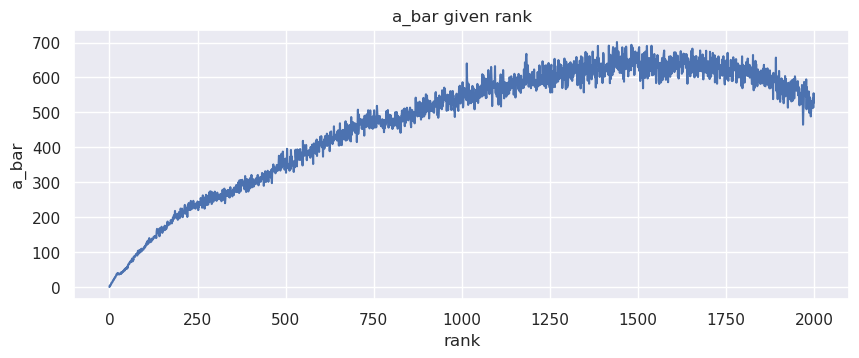

In [54]:
k = 2
print('First ' + str(k) + ' components of a_bar: ' + str(a_bar[0:k]))
print('Last ' + str(k) + ' components of a_bar: ' + str(a_bar[d-k:d]))
print('Minimum value of a_bar: ' + str(min(a_bar)))
plot_a_bar(a_bar)

#### Step 6: Encapsulate it into a Method

In [55]:
def compute_a_bar_direct_log(weights_by_rank_df):
    log_weights_by_rank = np.log(weights_by_rank_df)
    log_diff = -log_weights_by_rank.diff(axis=1).iloc[:, 1:]
    mean_diff = log_diff.mean(axis=0)
    a_bar = 1/mean_diff
    a_bar_1 = 0
    a_bar = np.insert(a_bar.values, 0, a_bar_1)
    return a_bar

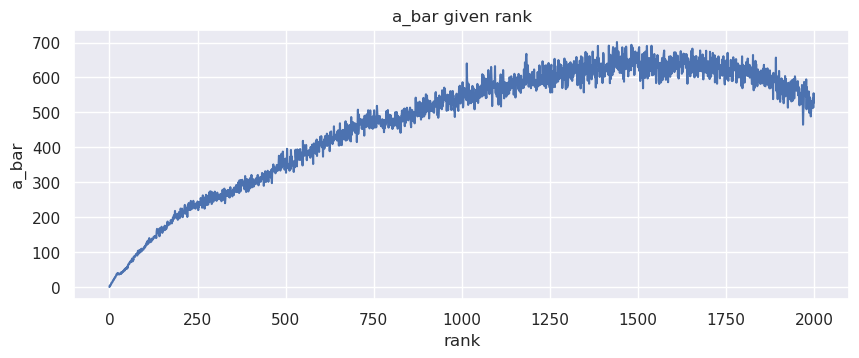

In [56]:
a_bar = compute_a_bar_direct_log(weights_by_rank_df=weights_by_rank)
plot_a_bar(a_bar)

#### Step 7: Smoothing $\bar a$

In [57]:
import scipy.ndimage.filters as filters
from scipy.signal import savgol_filter

def smooth_time_series(time_series, method, window=5, alpha=0.3, sigma=2, window_length=5, polyorder=2, frac=0.1):
    time_series = pd.Series(time_series)
    if method == 'moving_average':
        smoothed = time_series.rolling(window=window).mean()
    elif method == 'exponential_moving_average':
        smoothed = time_series.ewm(alpha=alpha).mean()
    elif method == 'gaussian':
        smoothed = pd.Series(filters.gaussian_filter(time_series, sigma))
    elif method == 'savitzky_golay':
        if window_length % 2 == 0:
            window_length += 1  # Ensure window_length is an odd integer
        smoothed = pd.Series(savgol_filter(time_series, window_length, polyorder))
    else:
        raise ValueError("Invalid smoothing method. Available methods are 'moving_average', 'exponential_moving_average', 'gaussian', 'savitzky_golay', and 'lowess'.")

    return np.array(smoothed)


##### Test it

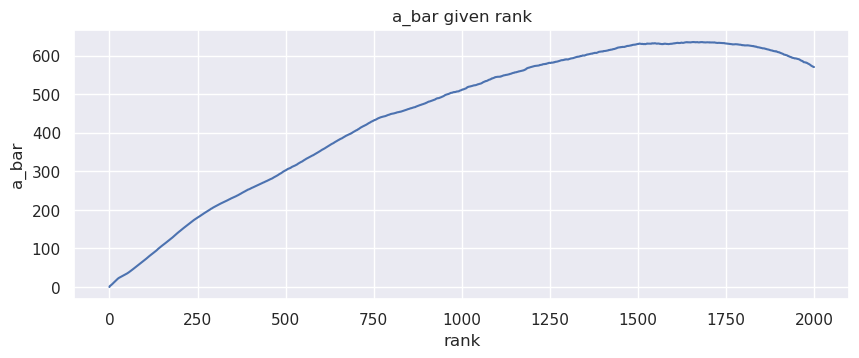

In [58]:
smoothed_a_bar = smooth_time_series(a_bar, method='exponential_moving_average', alpha=0.01)
plot_a_bar(smoothed_a_bar)

In [59]:
# Apply a moving average with a window size of 5
a_bar = pd.Series(a_bar)

window_size =50
smoothed_a_bar = a_bar.rolling(window=window_size).mean()

# Display the first few values of the smoothed vector
print(smoothed_a_bar.head())

0   NaN
1   NaN
2   NaN
3   NaN
4   NaN
dtype: float64


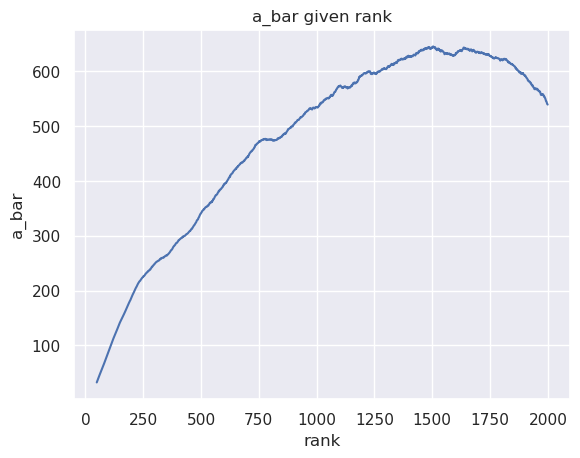

In [60]:
# Plot
fig, ax = plt.subplots()
ax.plot(smoothed_a_bar)
ax.set_title('a_bar given rank')
ax.set_xlabel("rank")
ax.set_ylabel("a_bar")
plt.show()

#### Step 8: Compute Raw $a$

In [61]:
def compute_a_given_a_bar(vector):
    ret = np.zeros(len(vector))
    ret[:-1] = -np.diff(vector)
    ret[-1] = vector[-1]
    return ret

def plot_a(vector):
    fig, ax = plt.subplots(figsize=(10, 3.5))
    ax.plot(vector)
    ax.set_title('a given rank')
    ax.set_xlabel("rank")
    ax.set_ylabel("a")
    plt.show()

-2.341858473311719
-2.341858473311719


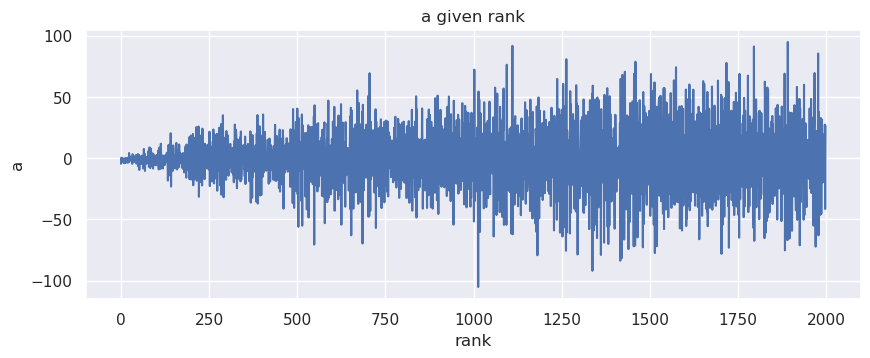

In [62]:
a_bar = compute_a_bar_direct_log(weights_by_rank_df=weights_by_rank)
a = compute_a_given_a_bar(a_bar)
print(a_bar[3]-a_bar[4])
print(a[3])
plot_a(a[:-1])

#### Step 9: Compute $a$ with smoothed $\bar a$

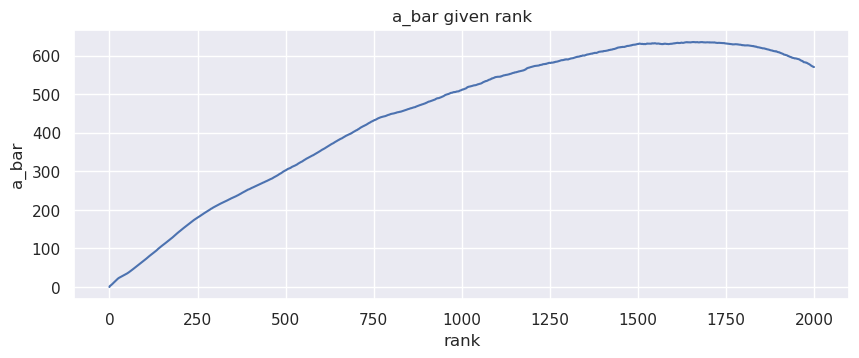

In [63]:
smoothed_a_bar = smooth_time_series(a_bar, method='exponential_moving_average', alpha=0.01)
plot_a_bar(smoothed_a_bar)

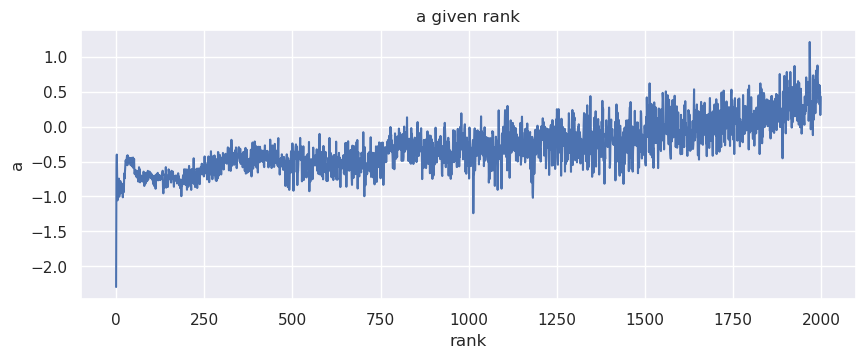

In [64]:
a = compute_a_given_a_bar(smoothed_a_bar)
plot_a(a[:-1])

#### Step 10: Smooth $a$ again.

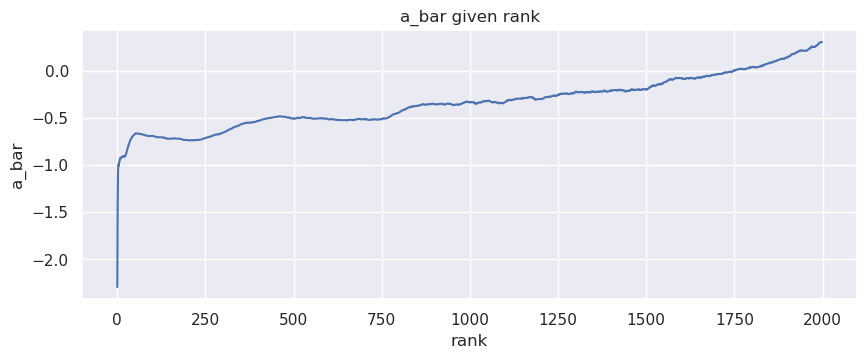

In [65]:
smoothed_a = smooth_time_series(a, method='exponential_moving_average', alpha=0.01)
plot_a_bar(smoothed_a[:-1])

### Step 2: Encapsulation of $a$ creation.

In [66]:
import scipy.ndimage.filters as filters
from scipy.signal import savgol_filter

def smooth_time_series(time_series, method, window=5, alpha=0.3, sigma=2, window_length=5, polyorder=2, frac=0.1):
    time_series = pd.Series(time_series)
    if method == 'moving_average':
        smoothed = time_series.rolling(window=window).mean()
    elif method == 'exponential_moving_average':
        smoothed = time_series.ewm(alpha=alpha).mean()
    elif method == 'gaussian':
        smoothed = pd.Series(filters.gaussian_filter(time_series, sigma))
    elif method == 'savitzky_golay':
        if window_length % 2 == 0:
            window_length += 1  # Ensure window_length is an odd integer
        smoothed = pd.Series(savgol_filter(time_series, window_length, polyorder))
    else:
        raise ValueError("Invalid smoothing method. Available methods are 'moving_average', 'exponential_moving_average', 'gaussian', 'savitzky_golay', and 'lowess'.")

    return np.array(smoothed)

def compute_a_bar_direct_log(weights_by_rank_df):
    log_weights_by_rank = np.log(weights_by_rank_df)
    log_diff = -log_weights_by_rank.diff(axis=1).iloc[:, 1:]
    mean_diff = log_diff.mean(axis=0)
    a_bar = 1/mean_diff
    a_bar_1 = 0
    a_bar = np.insert(a_bar.values, 0, a_bar_1)
    return a_bar

def compute_a_given_a_bar(vector):
    ret = np.zeros(len(vector))
    ret[:-1] = -np.diff(vector)
    ret[-1] = vector[-1]
    return ret

def plot_a(vector):
    fig, ax = plt.subplots(figsize=(10, 3.5))
    ax.plot(vector)
    ax.set_title('a given rank')
    ax.set_xlabel("rank")
    ax.set_ylabel("a")
    plt.show()

def get_a_given_rank(a, rank):
    return a[rank-1]

In [93]:
def compute_a_direct_log(weights_by_rank_df, alpha=0.01):
    a_bar = compute_a_bar_direct_log(weights_by_rank_df=weights_by_rank_df)
    #smoothed_a_bar = smooth_time_series(a_bar, method='exponential_moving_average', alpha=alpha)
    a = compute_a_given_a_bar(a_bar)#smoothed_a_bar)
    #smoothed_a = smooth_time_series(a, method='exponential_moving_average', alpha=alpha)
    return np.array(a)#smoothed_a)

#### Test

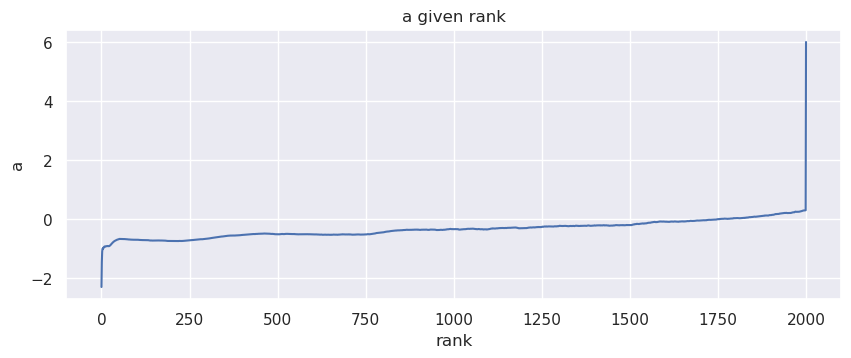

In [68]:
a = compute_a_direct_log(weights_by_rank_df= weights_by_rank)
plot_a(a)

## 2.2. Moment Matching Estimation of $a$.

Another way to estimate $a$ was introduce by Itkin in https://arxiv.org/pdf/2302.13707.pdf. The moment matching estimation of the components of $a$ is given by:

$$ 
a_1 = -1 - \frac{y_2}{y_1-y_2} , \quad
a_d = \frac{y_d}{y_{d-1}-y_d}, \\
a_k = \frac{y_k}{y_{k-1}-y_k} - \frac{y_{k+1}}{y_{k}-y_{k+1}}, \quad k = 2,..., d-1
$$

We take $y_k$ to be the average value through time of $y_k(t)$.

In [69]:
def compute_a_moment_matching(weights_by_rank_df, alpha=0.01):
    # Compute Expectation of Market Weights
    y_k = weights_by_rank_df.mean(axis=0)
    y_k = np.array(y_k)

    a = np.zeros(len(y_k))

    # Calculate a_1
    a[0] = -1 - (y_k[1] / (y_k[0] - y_k[1]))

    # Calculate a_d
    a[-1] = y_k[-1] / (y_k[-2] - y_k[-1])

    # Calculate a_k for k = 2, ..., d - 1
    for k in range(1, len(y_k) - 1):
        a[k] = (y_k[k] / (y_k[k - 1] - y_k[k])) - (y_k[k + 1] / (y_k[k] - y_k[k + 1]))

    smoothed_a = smooth_time_series(a, method='exponential_moving_average', alpha=alpha)

    return np.array(smoothed_a)

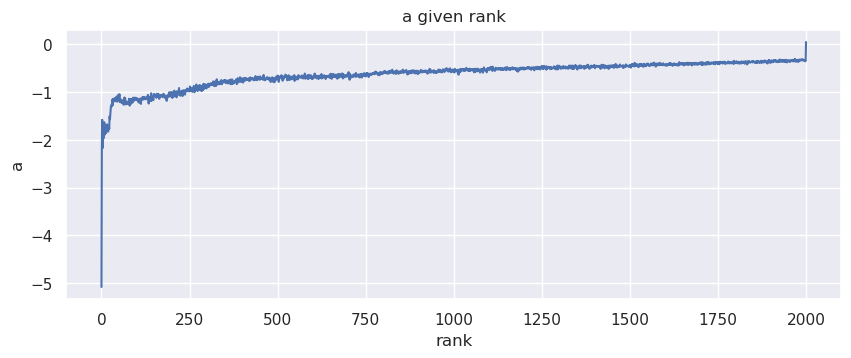

In [70]:
alpha = 0.0001
smoothed_a = compute_a_moment_matching(weights_by_rank_df=weights_by_rank, alpha=alpha)
plot_a(smoothed_a)

# 3. Backtesting

## 3.1. Pure Open Market Optimal Strategy 

The optimal strategy when we assume the Hybrid Jacobi Model under the Pure Open Market setting is given by 
$$
\hat \theta_{n_k(t)}(t) = \frac 1 2 \left( \frac{a_k}{Y_k(t)} + \frac{1}{\bar Y_1^N(t)}(2-\bar a_1^N)\right)
$$

This implies that at every time $t$ we should invest the following percentage of our total wealth in the $k$-ranked stock:
$$
\hat \theta_{n_k(t)}(t)(Y_k(t)) = \frac 1 2 \left( a_k + \frac{Y_k(t)}{\bar Y_1^N(t)}(2-\bar a_1^N)\right)
$$


### Step 1: Step by Step Computations

Define $N$ and $a$. 

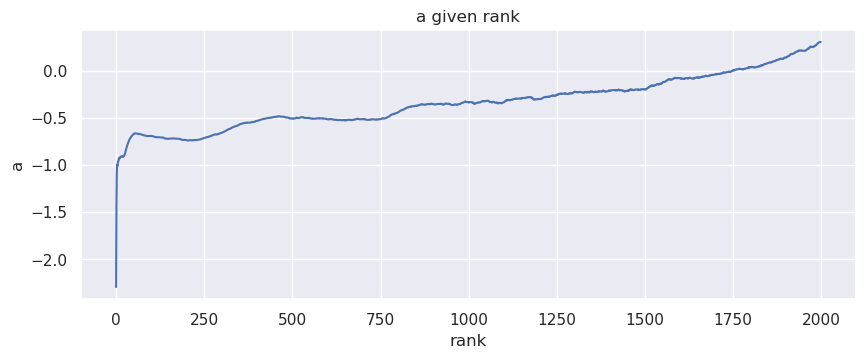

In [71]:
N = 10
a = compute_a_direct_log(weights_by_rank_df=weights_by_rank)
plot_a(a[:-1])

Let's now define a dataframe which will contain the percentage of our total wealth that we should have investited in the $k$-th ranked stock at each given month.

In [72]:
# First, let's set the value of N and compute the sum of the first N elements of the vector a. 
# Then, we will calculate the term (2 - 𝑎̅_1^N) to use it in the formula.
a_N = a[:N]  # Take the first N elements of the vector 'a'
a_1_N = a_N.sum()  # Compute the sum of the first N elements
term = 2 - a_1_N  # Compute the term (2 - 𝑎̅_1^N)

In [73]:
print(term)

13.607661164026396


Copy the first N columns of weights_by_rank.

In [74]:
optimal_strategy_percentage = weights_by_rank.iloc[:, :N].copy() 
optimal_strategy_percentage.head(3) 

,1,2,3,4,5,6,7,8,9,10
mthcaldt,,,,,,,,,,
1965-01-29,0.074882,0.058624,0.040830,0.030144,0.024896,0.023274,0.020658,0.017738,0.012739,0.011723
1965-02-26,0.071669,0.058544,0.038165,0.031831,0.023814,0.022908,0.020091,0.018226,0.012598,0.012578
1965-03-31,0.071080,0.056807,0.035534,0.032139,0.022956,0.021503,0.020365,0.018201,0.012488,0.011709


Compute the term $\bar Y_1^N(t)$ for all $k$ and $t$.

In [75]:
sum_topN_market_weights = weights_by_rank.iloc[:, :N].sum(axis=1)
sum_topN_market_weights.head(3)

mthcaldt
1965-01-29    0.315509
1965-02-26    0.310426
1965-03-31    0.302781
dtype: float64

Compute the term $\frac{Y_k(t)}{\bar Y_1^N(t)}$ for all $k$ and $t$.

In [76]:
topN_weights_by_rank = weights_by_rank.iloc[:, :N]
Yk_divided_by_sumY1N = topN_weights_by_rank.div(sum_topN_market_weights, axis=0)
Yk_divided_by_sumY1N.head(3)

,1,2,3,4,5,6,7,8,9,10
mthcaldt,,,,,,,,,,
1965-01-29,0.237337,0.185808,0.129409,0.095540,0.078909,0.073767,0.065476,0.056221,0.040377,0.037156
1965-02-26,0.230874,0.188593,0.122945,0.102541,0.076715,0.073797,0.064722,0.058713,0.040582,0.040519
1965-03-31,0.234756,0.187618,0.117360,0.106146,0.075818,0.071018,0.067259,0.060111,0.041243,0.038671


In [77]:
first_row_sum = Yk_divided_by_sumY1N.iloc[7].sum()
first_row_sum

1.0

Calculate the optimal strategy for each $k$ and $t$.

In [78]:
optimal_strategy_percentage = 0.5 * (a_N + Yk_divided_by_sumY1N.mul(term, axis=0))
optimal_strategy_percentage.head(3)

,1,2,3,4,5,6,7,8,9,10
mthcaldt,,,,,,,,,,
1965-01-29,0.466132,0.539681,0.332587,0.150116,0.031328,0.018005,-0.038648,-0.093991,-0.189712,-0.215496
1965-02-26,0.422161,0.558634,0.288605,0.197749,0.016400,0.018205,-0.043781,-0.077039,-0.188318,-0.192616
1965-03-31,0.448573,0.551997,0.250603,0.222280,0.010297,-0.000697,-0.026517,-0.067524,-0.183820,-0.205192


In [79]:
optimal_strategy = optimal_strategy_percentage.div(topN_weights_by_rank)
optimal_strategy.head(3)

,1,2,3,4,5,6,7,8,9,10
mthcaldt,,,,,,,,,,
1965-01-29,6.224873,9.205788,8.145667,4.980024,1.258332,0.773595,-1.870826,-5.298770,-14.891874,-18.382091
1965-02-26,5.890394,9.542087,7.561966,6.212432,0.688674,0.794698,-2.179086,-4.226920,-14.948610,-15.313576
1965-03-31,6.310836,9.717038,7.052416,6.916207,0.448559,-0.032417,-1.302088,-3.710023,-14.720218,-17.524681


In [80]:
first_row_sum = optimal_strategy_percentage.iloc[99].sum()
first_row_sum

1.0

### Step 2: Encapsultion of Computations

In [81]:
def compute_weights_optimal_pure_open(N, a, weights_by_rank):
    a_N = a[:N]  # Take the first N elements of the vector 'a'
    a_1_N = a_N.sum()  # Compute the sum of the first N elements
    term = 2 - a_1_N  # Compute the term (2 - 𝑎̅_1^N)
    sum_topN_market_weights = weights_by_rank.iloc[:, :N].sum(axis=1)
    topN_weights_by_rank = weights_by_rank.iloc[:, :N].copy()
    Yk_divided_by_sumY1N = topN_weights_by_rank.div(sum_topN_market_weights, axis=0)
    optimal_strategy_percentage = 0.5 * (a_N + Yk_divided_by_sumY1N.mul(term, axis=0))
    return optimal_strategy_percentage

In [82]:
def plot_strategy(strategy, date):
    fig, ax = plt.subplots(figsize=(10, 3.5))
    ax.plot(strategy.loc[date])
    ax.set_title('Weights of the Optimal Strategy')
    ax.set_xlabel("Rank")
    ax.set_ylabel("Proportion of Wealth")
    plt.show()

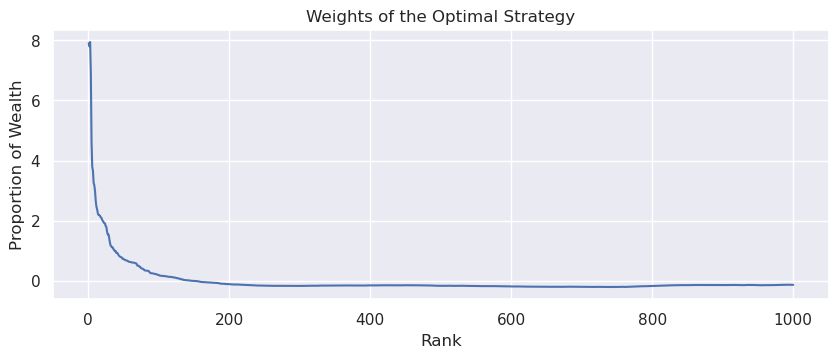

In [83]:
n = 1000
date = '2000-03-31'
a = compute_a_direct_log(weights_by_rank_df=weights_by_rank)
strategy = compute_weights_optimal_pure_open(N=n, a=a, weights_by_rank=weights_by_rank)
plot_strategy(strategy, date)

##### Tests

In [84]:
a = compute_a_direct_log(weights_by_rank_df=weights_by_rank)
N = 100
strategy = compute_weights_optimal_pure_open(N=N, a=a, weights_by_rank=weights_by_rank)

In [85]:
strategy.head(2)

,1,2,3,4,5,6,7,8,9,10,...,91,92,93,94,95,96,97,98,99,100
mthcaldt,,,,,,,,,,,,,,,,,,,,,
1965-01-29,3.682507,3.057731,2.086334,1.444862,1.100693,1.017692,0.848677,0.667914,0.357474,0.288043,...,-0.223960,-0.227172,-0.227712,-0.229108,-0.229651,-0.229610,-0.229609,-0.230177,-0.230557,-0.231525
1965-02-26,3.510937,3.081746,1.933438,1.569598,1.042735,1.005501,0.822103,0.708453,0.354612,0.349471,...,-0.222001,-0.223465,-0.223873,-0.224360,-0.224268,-0.224697,-0.226060,-0.226809,-0.227920,-0.229608


In [86]:
rows_sum_to_one = np.isclose(strategy.sum(axis=1), 1, rtol=1e-5)
print("Do all rows sum up to approximately 1? ", rows_sum_to_one.all())

Do all rows sum up to approximately 1?  True


Check Manually One of the Results

In [87]:
date = '1965-02-26'
rank = 3
N = 10
a = compute_a_direct_log(weights_by_rank_df=weights_by_rank)
optimal_strategy_percentage = compute_weights_optimal_pure_open(N, a, weights_by_rank)

sum_y_N = sum(weights_by_rank.loc[date, range(1,N+1)])
sum_a_N = sum(a[:N])
y_k = weights_by_rank.loc[date,rank]
a_k = a[rank-1]

total_perct = 0.5*(a_k + (y_k/sum_y_N)*(2-sum_a_N))

print('Manually compute the weight of the stock with rank', rank)
print('a vector component',rank,':', a_k)
print('Weight of rank',rank,':', y_k)
print('Sum of the first',N,'first market weights:',sum_y_N)
print('Sum of the first',N,'first components of the vector a:',sum_a_N)
print('Manually Calculated Optimal Strategy Percentage:',total_perct)
print('Dataframe Calculated Optimal Strategy Percentage:',optimal_strategy_percentage.loc[date, rank])

Manually compute the weight of the stock with rank 3
a vector component 3 : -1.0957862259241336
Weight of rank 3 : 0.03816533797928218
Sum of the first 10 first market weights: 0.31042568648747926
Sum of the first 10 first components of the vector a: -11.607661164026396
Manually Calculated Optimal Strategy Percentage: 0.2886049766597256
Dataframe Calculated Optimal Strategy Percentage: 0.2886049766597256


## 3.2 Mixed Open Market Optimal Strategy

The optimal strategy when we assume the Hybrid Jacobi Model under the Mixed Open Market setting is given by 
$$
\hat \theta_{n_k(t)}(t) = \frac 1 2 \left( \frac{a_k}{Y_k(t)} + (2-\bar a_1)\right), \quad k=1,...,N, \\ 

\hat \theta_{n_k(t)}(t) = \frac 1 2 \left( \frac{\bar a_{N+1}}{\bar Y_{N+1}(t)} + (2-\bar a_1)\right), \quad k=N+1,...,d, 
$$

This implies that at every time $t$ we should invest the following percentage of our total wealth in the $k$-ranked stock:
$$
\hat \theta_{n_k(t)}(t)(Y_k(t)) = \frac 1 2 \left( a_k + Y_k(t)(2-\bar a_1)\right), \quad k=1,...,N, \\ 

\hat \theta_{n_k(t)}(t) = \frac 1 2 Y_k(t) \left( \frac{\bar a_{N+1}}{\bar Y_{N+1}(t)} + (2-\bar a_1)\right), \quad k=N+1,...,d, 
$$


In [98]:
date = '1965-02-26'
rank = 1
N = 1000
a = compute_a_direct_log(weights_by_rank_df=weights_by_rank)
strategy = compute_weights_optimal_mixed_open(N, a, weights_by_rank)

sum_y_N = sum(weights_by_rank.loc[date, range(1,N+1)])
sum_a_N = sum(a[:N])
a_1_d = a.sum()  # Compute the sum of all elements in 'a'
y_k = weights_by_rank.loc[date,rank]
a_k = a[rank-1]

total_perct = 0.5*(a_k + (y_k)*(2-a_1_d))

print('Manually compute the weight of the stock with rank', rank)
print('a vector component',rank,':', a_k)
print('Weight of rank',rank,':', y_k)
print('Sum of the first',N,'first market weights:',sum_y_N)
print('Sum of the components of the vector a:',a_1_d)
print('Manually Calculated Optimal Strategy Percentage:',total_perct)
print('Dataframe Calculated Optimal Strategy Percentage:',strategy.loc[date, rank])

Manually compute the weight of the stock with rank 1
a vector component 1 : -4.571706586059913
Weight of rank 1 : 0.07166936705422422
Sum of the first 1000 first market weights: 0.9736594537435007
Sum of the components of the vector a: 0.0
Manually Calculated Optimal Strategy Percentage: -2.2141839259757323
Dataframe Calculated Optimal Strategy Percentage: -2.2141839259757323


In [97]:
def compute_weights_optimal_mixed_open(N, a, weights_by_rank):
    a_N = a[:N]  # Take the first N elements of the vector 'a'
    a_1_d = a.sum()  # Compute the sum of all elements in 'a'
    a_N_plus_1_d = a[N:].sum()  # Compute the sum of the elements from a_{N+1} to a_d
    term = 2 - a_1_d  # Compute the term (2 - 𝑎̅_1^d)

    # Compute the optimal strategy for k = 1, ..., N
    topN_weights_by_rank = weights_by_rank.iloc[:, :N].copy()
    optimal_strategy_percentage_topN = 0.5 * (a_N + topN_weights_by_rank.mul(term, axis=0))

    # Compute the optimal strategy for k = N+1, ..., d
    remaining_weights_by_rank = weights_by_rank.iloc[:, N:].copy()
    Y_N_plus_1_d = remaining_weights_by_rank.sum(axis=1)
    optimal_strategy_percentage_remaining = 0.5 * remaining_weights_by_rank.mul((a_N_plus_1_d / Y_N_plus_1_d + term), axis=0)

    # Combine the two results
    optimal_strategy_percentage = pd.concat([optimal_strategy_percentage_topN, optimal_strategy_percentage_remaining], axis=1)

    return optimal_strategy_percentage


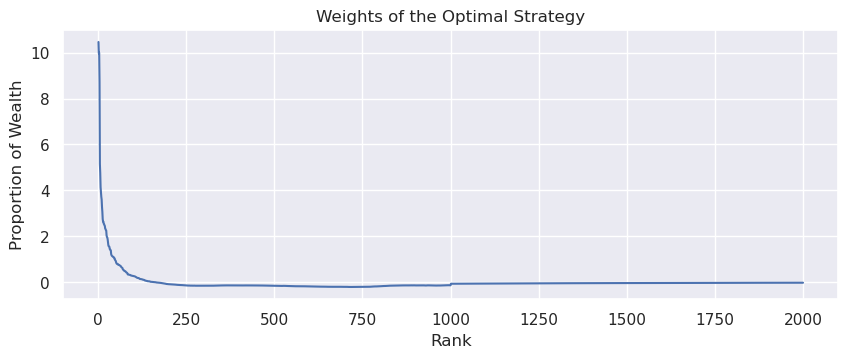

In [ ]:
n = 1000
date = '2000-03-31'
a = compute_a_direct_log(weights_by_rank_df=weights_by_rank)
strategy = compute_weights_optimal_mixed_open(N=n, a=a, weights_by_rank=weights_by_rank)
plot_strategy(strategy, date)

### Tests

In [ ]:
a = compute_a_direct_log(weights_by_rank_df=weights_by_rank)
N = 100
strategy = compute_weights_optimal_mixed_open(N=N, a=a, weights_by_rank=weights_by_rank)

In [ ]:
strategy.tail(2)

,1,2,3,4,5,6,7,8,9,10,...,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000
mthcaldt,,,,,,,,,,,,,,,,,,,,,
2022-10-31,20.316940,14.502409,8.648156,5.822644,4.563952,4.483579,4.085154,3.586617,3.537457,2.930747,...,-0.007274,-0.007269,-0.007258,-0.007248,-0.007226,-0.007220,-0.007203,-0.007176,-0.007173,-0.007150
2022-11-30,18.677131,15.287775,7.743571,4.698025,4.670572,4.594540,3.824506,3.440802,3.395363,3.036156,...,-0.006840,-0.006839,-0.006820,-0.006809,-0.006801,-0.006788,-0.006779,-0.006757,-0.006739,-0.006738


In [ ]:
rows_sum_to_one = np.isclose(strategy.sum(axis=1), 1, rtol=1e-5)
print("Do all rows sum up to approximately 1? ", rows_sum_to_one.all())

Do all rows sum up to approximately 1?  True


## 3.3. Backtesting Methods

In order to backtest, now I just need to calculate the independent returns made each month given my strategy. For each month I have to calculate this interest. Given a specific month, all I need is to multiply each percentage of stock I own by its generated returns and add (?) all of them.

### Step 1: Given a fixed month, calculate the returns of my strategy that month.

In [ ]:
def interest_optimal_one_period(date, optimal_strategy_percentage):
    try:

        total_interest = 0
        for rank in list(optimal_strategy_percentage.columns):
            percentage = optimal_strategy_percentage.loc[date, rank]
            interest = 1 + get_return_given_rank(date, rank)
            total_interest += (percentage * interest)
        return total_interest
    except KeyError:
        print(f"Date {date} not found in DataFrame index")
        return None

In [ ]:
date = '1978-02-28'
N=100
a = compute_a_direct_log(weights_by_rank_df=weights_by_rank)
optimal_strategy_percentage = compute_weights_optimal_pure_open(N=N, a=a, weights_by_rank=weights_by_rank)
interest_optimal_one_period(date, optimal_strategy_percentage)

0.6419374216612266

### Step 2: Calculate the returns of my strategy over the whole period.

In [ ]:
def backtest(dates, strategy):
    cumulative_interest = 1 
    interests = []
    cumulative_interests = []
    for date in dates:
        interest = interest_optimal_one_period(date, strategy)
        interests.append(interest)
        cumulative_interest *= interest
        cumulative_interests.append(cumulative_interest)
    return interests, cumulative_interests

### Step 3: Plots

In [ ]:
def plot_interests(dates, interests):
    fig, ax = plt.subplots(figsize=(10, 3.5))
    ax.plot(dates, interests)
    ax.set_xlabel("Date")
    ax.set_ylabel("Interests")
    ax.set_title("Interests over Time")
    plt.show()
    plt.close()

In [ ]:
def plot_cumulative_interests(dates, cumulative_interests):
    fig, ax = plt.subplots(figsize=(10, 3.5))
    ax.plot(dates, cumulative_interests)
    ax.set_xlabel("Date")
    ax.set_ylabel("Cumulative Interests")
    ax.set_title("Cumulative Interests over 1973-2022")
    plt.show()
    plt.close()

In [ ]:
def plot_cumulative_interests_years(dates, cumulative_interests, years):
    months = 12 * years
    fig, ax = plt.subplots(figsize=(10, 3.5))
    ax.plot(dates[0:months], cumulative_interests[0:months])
    ax.set_xlabel("Date")
    ax.set_ylabel("Cumulative Interests")
    ax.set_title("Cumulative Interests during the first " + str(years) + " years.")
    plt.show()
    plt.close()

## 3.4. Final Results: Backtesting

### Pure Open Market

In [ ]:
N = 1
a = compute_a_direct_log(weights_by_rank_df=weights_by_rank)
strategy = compute_weights_optimal_pure_open(N=N, a=a, weights_by_rank=weights_by_rank)
dates_list = strategy.index.tolist()

interests, cumulative_interests = backtest(dates=dates_list, strategy=strategy)

First cumulative interests  [1.0054943564141525, 0.9869085087909706, 1.0129286954634258, 1.0464099154007707, 1.008971277998239]
Mean Interests:  1.0069404289408126


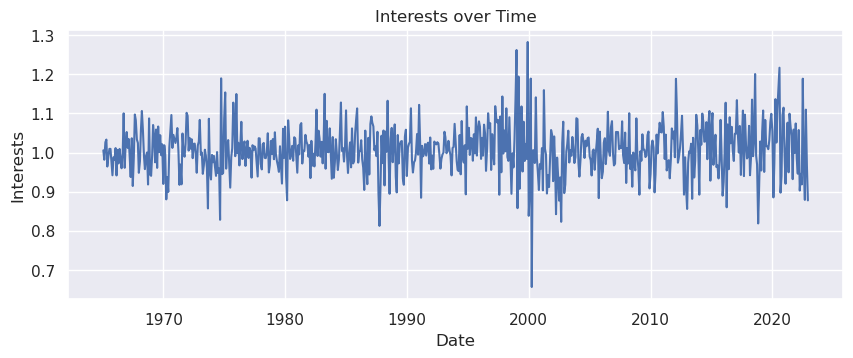

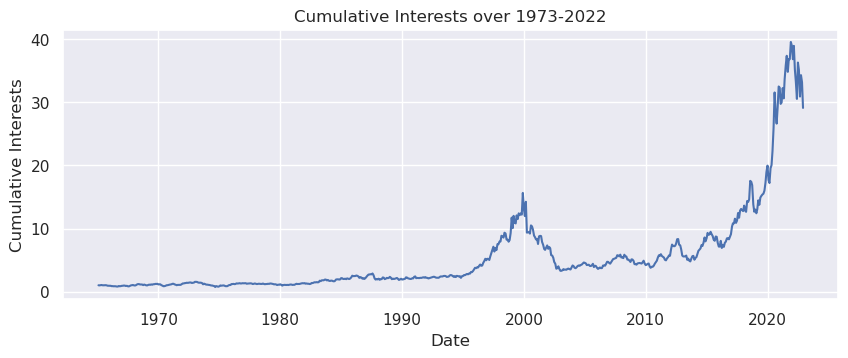

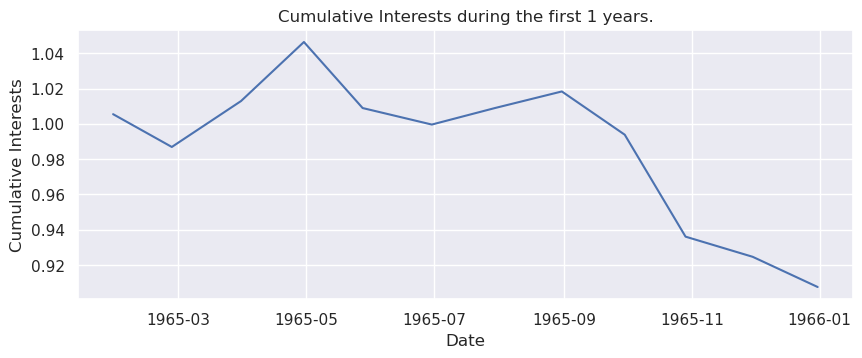

In [ ]:
years = 1
print('First cumulative interests ', cumulative_interests[0:5])
print('Mean Interests: ', np.mean(interests))
plot_interests(dates_list, interests)
plot_cumulative_interests(dates=dates_list, cumulative_interests=cumulative_interests)
plot_cumulative_interests_years(dates=dates_list, cumulative_interests=cumulative_interests, years=years)

### Mixed Open Market

In [ ]:
N = 1
a = compute_a_direct_log(weights_by_rank_df=weights_by_rank)
strategy = compute_weights_optimal_mixed_open(N=N, a=a, weights_by_rank=weights_by_rank)
dates_list = strategy.index.tolist()

interests, cumulative_interests = backtest(dates=dates_list, strategy=strategy)

First cumulative interests  [0.9611227272304239, 0.7507226398434269, 0.6344559110568446, 1.2097777819585218, 1.6266691382721807]
Mean Interests:  0.9670507728535346


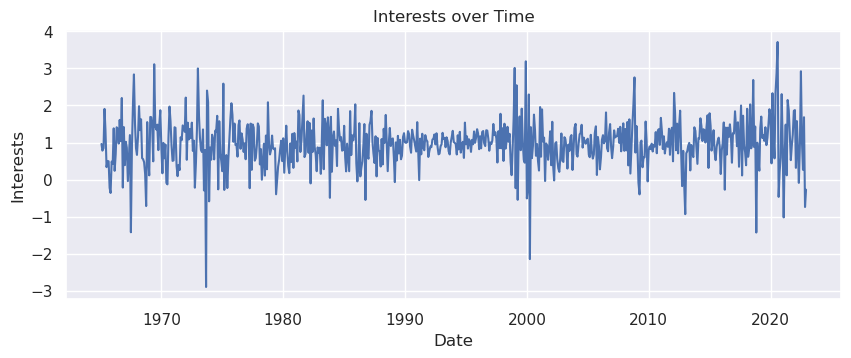

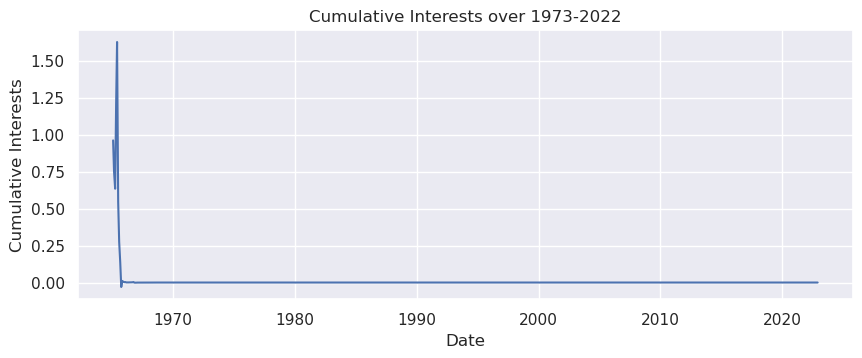

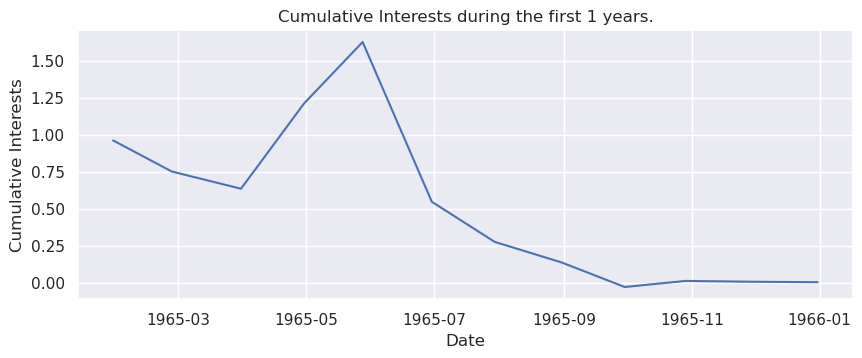

In [ ]:
years = 1
print('First cumulative interests ', cumulative_interests[0:5])
print('Mean Interests: ', np.mean(interests))
plot_interests(dates_list, interests)
plot_cumulative_interests(dates=dates_list, cumulative_interests=cumulative_interests)
plot_cumulative_interests_years(dates=dates_list, cumulative_interests=cumulative_interests, years=years)